In [1]:
import numpy as np
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt
import japanize_matplotlib
from jax.example_libraries import optimizers
from functools import partial

# 3層NNのGD学習

In [2]:
rng = jax.random.PRNGKey(42)
rng, subkey = jax.random.split(rng, num=2)

m = 100 #中間層の次元数
a = jax.random.normal(subkey,(m,)) #中間層と出力層の間の重み（今回はハイパラ）
n = 50 #データ数
d = 10 #入力層の次元数

In [3]:
# 教師データ（入出力の組）作成
rng, subkey = jax.random.split(rng, num=2)
G = jax.random.normal(subkey, (d,d))
X = jnp.zeros((d, n)) #入力
Y = jnp.zeros(n) #出力

for j in range(n):
    rng, subkey = jax.random.split(rng, num=2)
    x = jax.random.normal(subkey, (d,))
    x = x/jnp.linalg.norm(x)
    y = x.T@G@x
    X = X.at[:,j].set(x)
    Y = Y.at[j].set(y)

## ニューラルネットワークの定義(vmap使わない版)

In [1]:
#３層NN（バッチを一気に処理するためにちょっとめんどい実装に…）
# Jax使うなら、jax.vmapとかでバッチ次元の拡張したほうがスマートだと思う(下に追記)
def f(W, x):
    return (jnp.sum(jnp.tile(a.reshape(len(a),1),x.shape[-1]) * jax.nn.relu(W.T @ x), axis=0))/jnp.sqrt(m)

In [8]:
@jax.jit
def L(W):#二乗誤差
    return 0.5*jnp.linalg.norm(f(W, X) - Y)**2

In [4]:
def step(L, W, eta):
    gs = jax.grad(L)(W)
    return W - eta*gs

In [9]:
def GD(max_itr, eta):
    rng = jax.random.PRNGKey(np.random.randint(255))
    W = jax.random.normal(rng, (d,m))
    ret_list = jnp.zeros(max_itr)
    for i in range(max_itr):
        W = step(L, W, eta)
        ret_list = ret_list.at[i].set(L(W))
        # print(ret_list[i])
    return ret_list

In [10]:
eta = 0.9
max_itr = 200
L_list = GD(max_itr, eta)

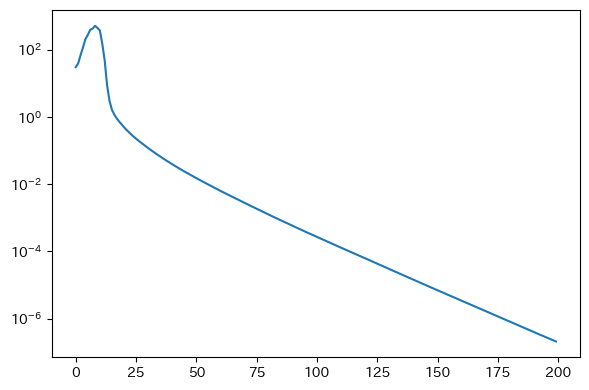

In [11]:
fig = plt.figure(figsize=(6, 4), tight_layout=True)
ax = fig.add_subplot(111, yscale="log")
ax.plot(range(max_itr), L_list);

# jax.vmap使う版

In [5]:
def NN(W, x):
    return a.T @ jax.nn.relu(W.T @ x)/jnp.sqrt(m)

In [6]:
batch_NN = jax.vmap(NN ,in_axes=[None, -1]) #Wは非バッチ、バッチ次元は末尾

In [7]:
Y_b = Y.reshape(1,len(Y))
@jax.jit
def Loss(W):#二乗誤差
    return 0.5*jnp.linalg.norm(batch_NN(W, X) - Y_b)**2

In [8]:
def GD2(max_itr, eta):
    rng = jax.random.PRNGKey(np.random.randint(255))
    W = jax.random.normal(rng, (d,m))
    ret_list = jnp.zeros(max_itr)
    for i in range(max_itr):
        W = step(Loss, W, eta)
        ret_list = ret_list.at[i].set(Loss(W))
    return ret_list  

In [9]:
eta = 0.9
max_itr = 200
L_list = GD2(max_itr, eta)

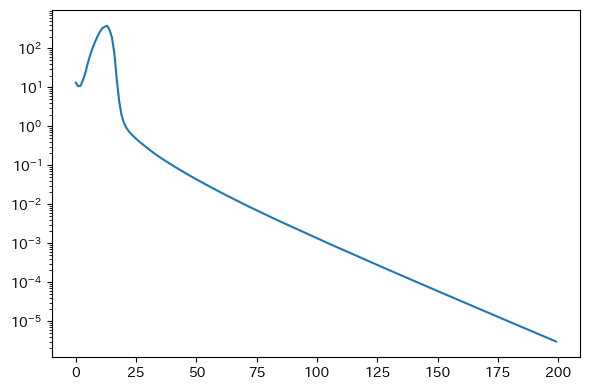

In [10]:
fig = plt.figure(figsize=(6, 4), tight_layout=True)
ax = fig.add_subplot(111, yscale="log")
ax.plot(range(max_itr), L_list);